# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import datetime
import pvlib
from pvlib import clearsky, atmosphere, solarposition, irradiance
from pvlib.location import Location
from pvlib.iotools import read_tmy3
import warnings
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
import quantecon as qe
import scipy

# Reading csv files

In [2]:
DataSource = 'Location 1' ### Location 1: Yverdon-les-Bains, Switzerland; Location 2: Oahu, Hawaii
resolution = '1min'
digit = 20 # Number of states
if DataSource == 'Location 1':   
    st1 = 0.33 # if avergae value is less tna st1 and the standard deviation is less than std1, that day is assumed to be cloudy
    st2 = 0.66 # if avergae value is more tna st2 and the standard deviation is less than std1, that day is assumed to be sunny
    std1 = 0.1 # if standard deviation is more than std1, that day is assumed to be partly cloudy
elif DataSource == 'Location 2':
    st1 = 0.1
    st2 = 0.9
    std1 = 0.7
    
cwd = os.getcwd()
csv_file = cwd + "/Data/Météo_16_17_18.csv"
DF_1 = pd.read_csv(open(csv_file, 'rb'), encoding='ISO-8859-1', delimiter=';', dtype='unicode')
csv_file = cwd + "/Data/GHI_20100401_20101231.csv"
DF_2_1 = pd.read_csv(open(csv_file, 'rb'), encoding='ISO-8859-1', delimiter=',', dtype='unicode')
csv_file = cwd + "/Data/GHI_20110101_20111031.csv"
DF_2_2 = pd.read_csv(open(csv_file, 'rb'), encoding='ISO-8859-1', delimiter=',', dtype='unicode')

if DataSource == 'Location 1':
    DF = DF_1
    DF['Time'] = pd.to_datetime(DF["Date et Heure"])
    DF = DF.set_index('Time')
    DF.index = DF.index.tz_localize(tz='CET', ambiguous='NaT', nonexistent='NaT')
    DF.index = DF.index.tz_convert('UTC')
    DF = DF.shift(periods=1*60, fill_value=0)
    DF['GHI'] = DF['Rayonnement Direct moyen [W/m2]']
elif DataSource == 'Location 2':
    DF = pd.concat([DF_2_1, DF_2_2], axis=0)
    DF['Time'] = DF['DATE (MM/DD/YYYY)'] + ' ' +  DF['HST']
    DF['Time'] = pd.to_datetime(DF['Time'])
    DF = DF.set_index('Time')
    DF.index = DF.index.tz_localize(tz='US/Hawaii', ambiguous='NaT', nonexistent='NaT')
    DF['GHI'] = DF['Global Horizontal [W/m^2]']   
DF = DF[['GHI']]
DF['GHI'] = DF['GHI'].astype(float)
DF.head()

,GHI
Time,
2015-12-31 23:00:00+00:00,0.0
2015-12-31 23:01:00+00:00,0.0
2015-12-31 23:02:00+00:00,0.0
2015-12-31 23:03:00+00:00,0.0
2015-12-31 23:04:00+00:00,0.0


# Removing the outliers

In [3]:
if DataSource == 'Location 1':
    DF = DF[np.abs(DF-DF.mean()) <= (0.1*DF.std())]
elif DataSource == 'Location 2':
    DF = DF[np.abs(DF-DF.mean()) <= (10*DF.std())]
DF = DF.resample('min').mean()
Dmin = DF.index.min()
Dmax = DF.index.max()
Dmin = Dmin + datetime.timedelta(days=1)
Dmin = Dmin.strftime('%Y-%m-%d')
Dmax = Dmax - datetime.timedelta(days=1)
Dmax = Dmax.strftime('%Y-%m-%d')
DF = DF[Dmin:Dmax]

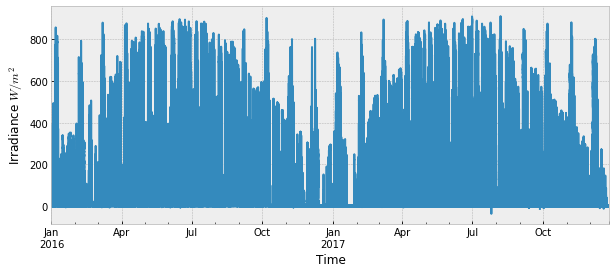

In [4]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

plt.rcParams['figure.figsize']=(10,4)
plt.style.use('bmh')
fig, ax = plt.subplots()
DF[:]['GHI'].plot(label='G')
ax.set_ylabel('Irradiance $W/m^2$');

# Derive the maximum W/m2 (Using pvlib package)

In [5]:
Dmin = DF.index.min()
Dmax = DF.index.max()

if DataSource == 'Location 1':
    ylb = Location(46.78, 6.64, altitude=435)
    times = pd.date_range(start=Dmin, end=Dmax, tz='UTC', freq='1min')
elif DataSource == 'Location 2':
    ylb = Location(19.8968, -155.5828, altitude=6)
    times = pd.date_range(start=Dmin, end=Dmax, tz='US/Hawaii', freq='1min')
cs = ylb.get_clearsky(times)

# Finding the clear sky index (limiting the index between 0 and 1)

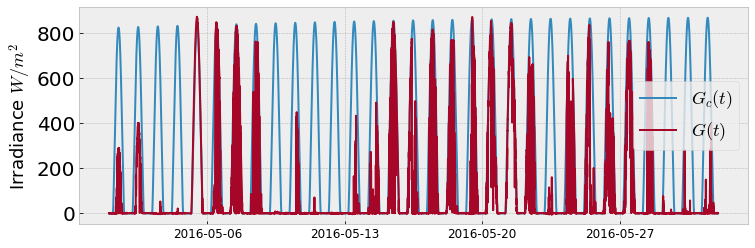

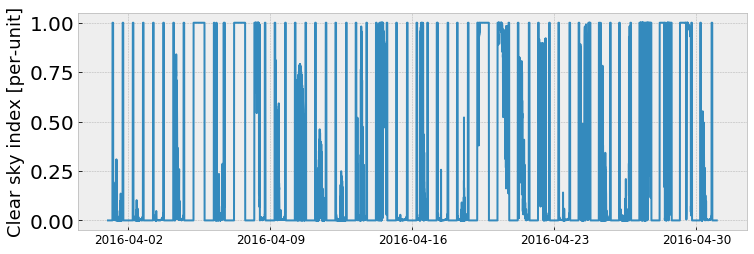

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

DF['CGHI'] = cs['ghi']
DF['CSI'] = np.divide(DF['GHI'], DF['CGHI'], out=np.empty_like(DF['CGHI']), where=DF['CGHI']>50)
DF['CSI'] = np.minimum(DF['CSI'], 1)
DF['CSI'] = np.maximum(DF['CSI'], 0)

DF['CSI'] = DF['CSI'].fillna(0)

plt.rcParams['figure.figsize']=(12,4)
plt.style.use('bmh')
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=20) 

fig, ax = plt.subplots()
if DataSource == 'Location 1':
    plt.plot(DF['2016-05']['CGHI'], label='$G_c(t)$');
    plt.plot(DF['2016-05']['GHI'], label='$G(t)$')
elif DataSource == 'Location 2':
    plt.plot(DF['2010-05']['CGHI'], label='$G_c(t)$');
    plt.plot(DF['2010-05']['GHI'], label='$G(t)$')
plt.legend(fontsize=18)
ax.set_ylabel('Irradiance $W/m^2$',fontsize=18);
plt.show()

fig, ax = plt.subplots()
if DataSource == 'Location 1':
    plt.plot(DF['2016-04']['CSI']);
elif DataSource == 'Location 2':
    plt.plot(DF['2010-04']['CSI']);
ax.set_ylabel('Clear sky index [per-unit]',fontsize=18);
plt.show()

## Finding mean and standard deviation 

In [7]:
df = pd.DataFrame()
df['a'] = DF[DF['CGHI']>50]['CSI']
print('1-minute:')
print('- mean:', df['a'].mean())
print('- std:', df['a'].std())
print('- autocorr:', df['a'].autocorr(lag = 1))

df = pd.DataFrame()
df['a'] = DF[DF['CGHI']>50]['CSI']
df = df.resample('10min').mean()
print('10-minute:')
print('- mean:', df['a'].mean())
print('- std:', df['a'].std())
print('- autocorr:', df['a'].autocorr(lag = 1))

df = pd.DataFrame()
df['a'] = DF[DF['CGHI']>50]['CSI']
df = df.resample('1H').mean()
print('1-hour:')
print('- mean:', df['a'].mean())
print('- std:', df['a'].std())
print('- autocorr:', df['a'].autocorr(lag = 1))

1-minute:
- mean: 0.37014463937578623
- std: 0.425033172608174
- autocorr: 0.9722549991206328
10-minute:
- mean: 0.3690281532464324
- std: 0.41367328255552116
- autocorr: 0.9498291486848006
1-hour:
- mean: 0.36309370042504535
- std: 0.397138421518687
- autocorr: 0.8975171201750464


# Change the resolution

In [8]:
DF = DF.resample(resolution).mean()

# Finding daily mean and standard deviation + the parameters of beta distribution for each month

1-day:
mean: 0.35510877182476835
std: 0.33640653855928304
autocorr: 0.3862655479529539
daily_a: [0.29485134 0.35842206 0.57662736 0.27533052 0.56642021 0.94586904
 0.85029849 0.47822316 0.50029884 1.28952149 0.58428908 0.33340621]
daily_b: [0.80671858 3.22939247 0.75005708 0.40751951 1.4340126  0.90927552
 0.77991188 0.49737677 1.46522578 0.91969152 1.8916714  1.03159133]


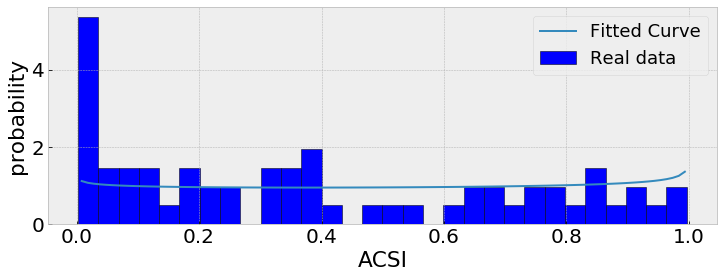

In [10]:
df = pd.DataFrame()
df['a'] = DF[DF['CGHI']>50]['CSI']
df = df.resample('1D').mean()
df =df.dropna()
print('1-day:')
print('mean:', df['a'].mean())
print('std:', df['a'].std())
print('autocorr:', df['a'].autocorr(lag = 1))

daily_mean = df['a'].mean()
daily_std = df['a'].std()

daily_a = np.zeros(12)
daily_b = np.zeros(12)
for m in range(12):
    daily_a[m], daily_b[m], temp1, temp2 = scipy.stats.beta.fit(df[pd.to_datetime(df.index.to_series()).dt.month == m + 1]['a'])
print('daily_a:', daily_a)
print('daily_b:', daily_b)

plt.rcParams['figure.figsize']=(12,4)
plt.style.use('bmh')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
for m in [5]:
    x = np.linspace(scipy.stats.beta.ppf(0.01, daily_a[m], daily_b[m]),
                    scipy.stats.beta.ppf(0.99, daily_a[m], daily_b[m]), 100)
    ax.plot(x, scipy.stats.beta.pdf(x, daily_a[m], daily_b[m]))
    ax.hist(df[pd.to_datetime(df.index.to_series()).dt.month == m]['a'], color = 'blue', edgecolor = 'black', bins = int (30), density = True)
plt.xlabel("ACSI")
plt.ylabel("probability")
plt.legend(["Fitted Curve", "Real data"])
plt.savefig('Figures/beta.pdf',bbox_inches='tight')
df.to_csv(r'Figures/csi.csv')

# Finding 3 transition matrix (for sunny, partly cloudy, and cloudy)

In [11]:
def transition_matrix(transitions,digit):
    n = 1 + digit #number of states
    M = [[0]*n for _ in range(n)]
    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1
    #now convert to probabilities:
    k = 0
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
        else:
            row[k] = 1
        k = k + 1
    return M


df = pd.DataFrame()
df['a'] = DF[DF['CGHI']>50]['CSI']

bins = np.arange(0,1,1/digit)

df2 = df.resample('1D').mean()
df3 = df.resample('1D').std()

df['b'] = df.index.strftime('%Y-%m-%d')

Dates = df2[(df2['a']<st1) & (df3['a']<=std1)].index.strftime('%Y-%m-%d')
filtered1 = df[df['b'].isin(Dates)]
transitions1 = np.digitize(filtered1['a'], bins, right=True)
TM1 = transition_matrix(transitions1,digit)

Dates = df2[((df2['a']<st2) & (df2['a']>=std1)) | (df3['a']>=st1)].index.strftime('%Y-%m-%d')
filtered2 = df[df['b'].isin(Dates)]
transitions2 = np.digitize(filtered2['a'], bins, right=True)
TM2 = transition_matrix(transitions2,digit)

Dates = df2[(df2['a']>=st2) & (df3['a']<=std1)].index.strftime('%Y-%m-%d')
filtered3 = df[df['b'].isin(Dates)]
transitions3 = np.digitize(filtered3['a'], bins, right=True)
TM3 = transition_matrix(transitions3,digit)

# State-of-the-art model (1 Transition matrix)

In [12]:
df = pd.DataFrame()
df['a'] = DF[DF['CGHI']>50]['CSI']
transitions = np.digitize(df['a'], bins, right=True)
TM = transition_matrix(transitions, digit)

# Plotting 4 Transition matrix

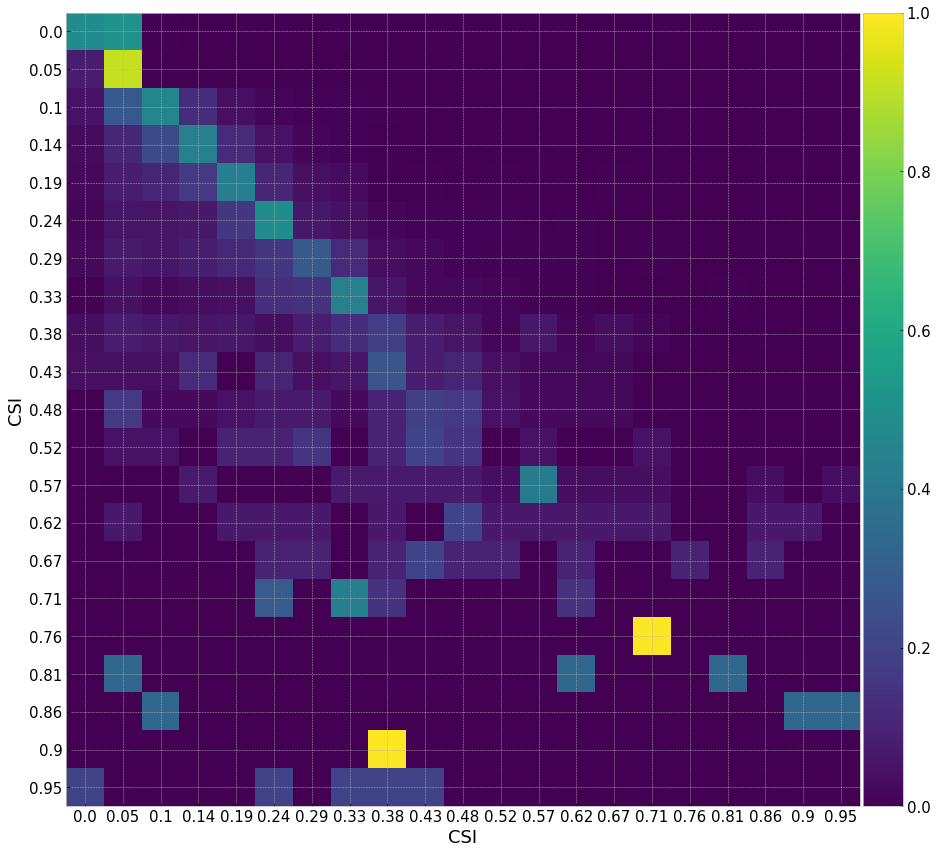

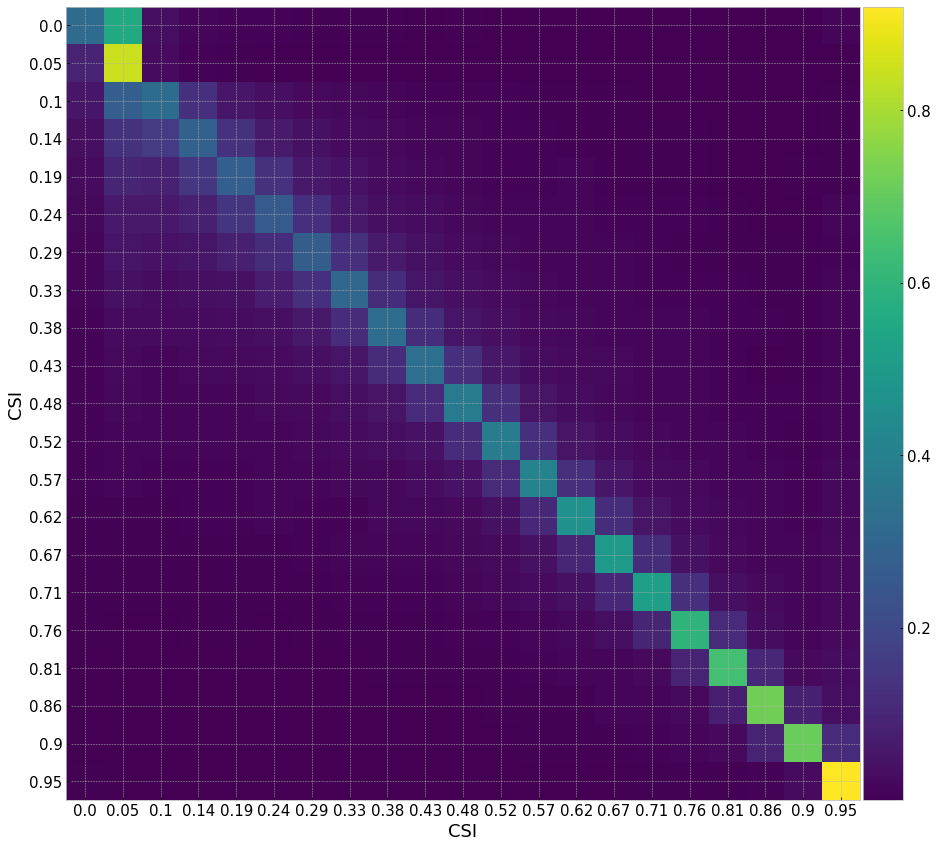

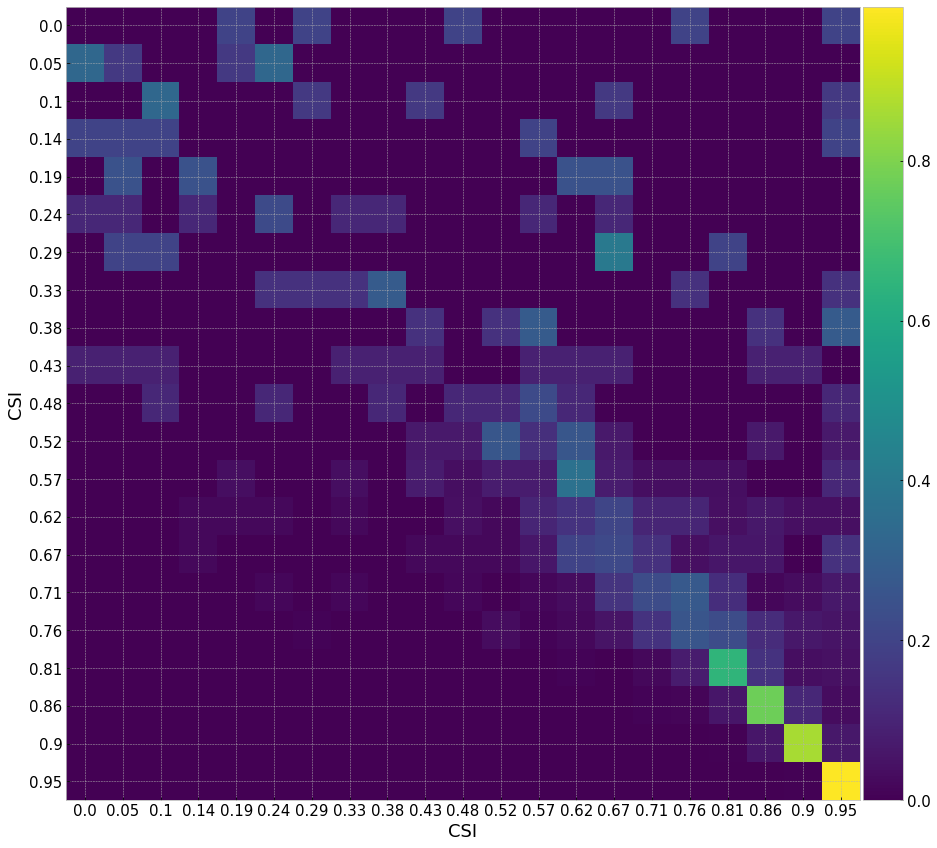

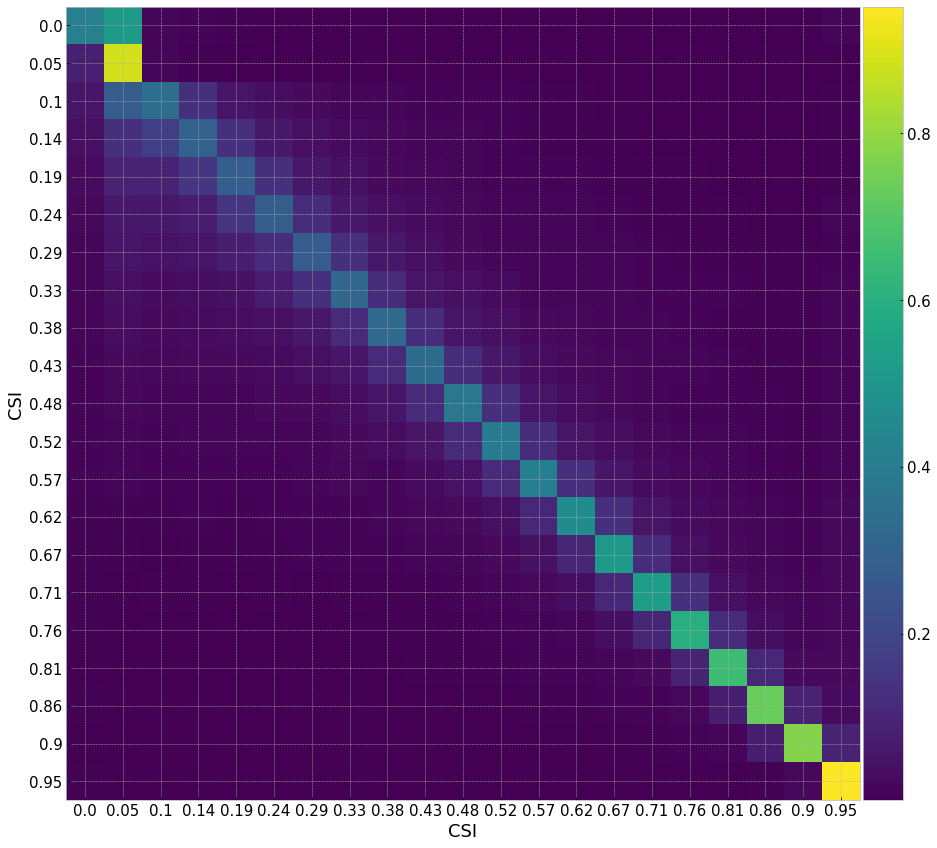

In [13]:
plt.rcParams['figure.figsize']=(15,15)
plt.style.use('bmh')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams.update({'font.size': 15})
bins = np.arange(0, 1, 1/(digit+1)).round(2)

fig, ax = plt.subplots()
im = ax.imshow(TM1)
ax.set_xticks(range(0,digit+1))
ax.set_yticks(range(0,digit+1))
plt.xlabel("CSI")
plt.ylabel("CSI")
ax.set_xticklabels(bins)
ax.set_yticklabels(bins)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.savefig('Figures/TM1.pdf',bbox_inches='tight')
plt.show()


plt.rcParams['figure.figsize']=(15,15)
fig, ax = plt.subplots()
im = ax.imshow(TM2)
ax.set_xticks(range(0,digit+1))
ax.set_yticks(range(0,digit+1))
plt.xlabel("CSI")
plt.ylabel("CSI")
ax.set_xticklabels(bins)
ax.set_yticklabels(bins)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.savefig('Figures/TM2.pdf',bbox_inches='tight')
plt.show()


plt.rcParams['figure.figsize']=(15,15)
fig, ax = plt.subplots()
im = ax.imshow(TM3)
ax.set_xticks(range(0,digit+1))
ax.set_yticks(range(0,digit+1))
plt.xlabel("CSI")
plt.ylabel("CSI")
ax.set_xticklabels(bins)
ax.set_yticklabels(bins)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.savefig('Figures/TM3.pdf',bbox_inches='tight')
plt.show()

plt.rcParams['figure.figsize']=(15,15)
fig, ax = plt.subplots()
im = ax.imshow(TM)
ax.set_xticks(range(0,digit+1))
ax.set_yticks(range(0,digit+1))
plt.xlabel("CSI")
plt.ylabel("CSI")
ax.set_xticklabels(bins)
ax.set_yticklabels(bins)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.savefig('Figures/TM.pdf',bbox_inches='tight')
plt.show()

# Explaining the Method

- First for each day, generate a random number using mean and std values equal to 0.33 and 0.31, respectively.
- Second, digitize this random number.
- Third, using the transition matrix presented above, generate the "clear sky index" for each second. 

# Implementing the Method (using package quantecon for generating Markov Chain)

In [14]:
bins = np.arange(0,1,1/digit)

if resolution == '1min':
    ts_len = 24 * 60
elif resolution == '10min':
    ts_len = 24 * 6
elif resolution == '1h':
    ts_len = 24
series = np.array([])
mc1 = qe.MarkovChain(TM1)
mc2 = qe.MarkovChain(TM2)
mc3 = qe.MarkovChain(TM3)
days_data = DF.resample('D').mean()
for day in days_data.index:
    mean_state = np.random.beta(daily_a[day.month - 1], daily_b[day.month - 1])
    mean_state = np.digitize(mean_state, bins, right=True)
    if mean_state / (np.sqrt(np.size(TM1))-1) < st1:
        initial_state = mean_state
        X = mc1.simulate(init = int(initial_state), ts_length=ts_len) / (np.sqrt(np.size(TM1))-1)
    elif (mean_state / (np.sqrt(np.size(TM2))-1) >= st1) & (mean_state / (np.sqrt(np.size(TM2))-1) < st2):
        initial_state = mean_state
        X = mc2.simulate(init = int(initial_state), ts_length=ts_len) / (np.sqrt(np.size(TM2))-1)
    else:
        initial_state = mean_state
        X = mc3.simulate(init = int(initial_state), ts_length=ts_len) / (np.sqrt(np.size(TM3))-1)    
    series = np.append(series, X)
DF['CSI_sim'] =  series
DF['GHI_sim'] = DF['CSI_sim'] * DF['CGHI']

warnings.filterwarnings("ignore") # specify to ignore warning messages

DF['CSI_sim'] = np.divide(DF['GHI_sim'], DF['CGHI'], out=np.empty_like(DF['GHI_sim']), where=DF['CGHI']>50)
DF['CSI_sim'] = np.minimum(DF['CSI_sim'], 1)
DF['CSI_sim'] = np.maximum(DF['CSI_sim'], 0)

# Implementing state-of-the-art method

In [15]:
df = pd.DataFrame()
df['a'] = DF[DF['CGHI']>50]['CSI']
df = df.resample('1D').mean()
daily_mean = df['a'].mean()
daily_std = df['a'].std()

series = np.array([])
mc = qe.MarkovChain(TM)
days_data = DF.resample('D').mean()
for day in days_data.index:
    initial_state = np.digitize(daily_mean, bins, right=True)
    X = mc.simulate(init = int(initial_state), ts_length=ts_len) / (np.sqrt(np.size(TM))-1)
    series = np.append(series, X)
DF['CSI_sim2'] =  series
DF['GHI_sim2'] = DF['CSI_sim2'] * DF['CGHI']

warnings.filterwarnings("ignore") # specify to ignore warning messages

DF['CSI_sim2'] = np.divide(DF['GHI_sim2'], DF['CGHI'], out=np.empty_like(DF['GHI_sim2']), where=DF['CGHI']>50)
DF['CSI_sim2'] = np.minimum(DF['CSI_sim2'], 1)
DF['CSI_sim2'] = np.maximum(DF['CSI_sim2'], 0)

# Plotting Simulated Generation and Comparing with Real data

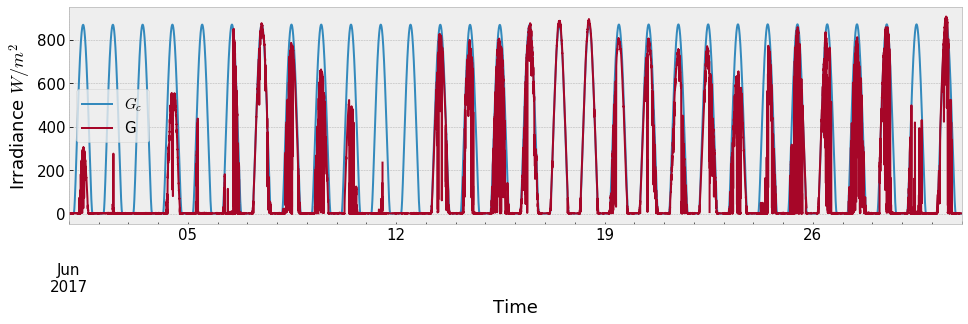

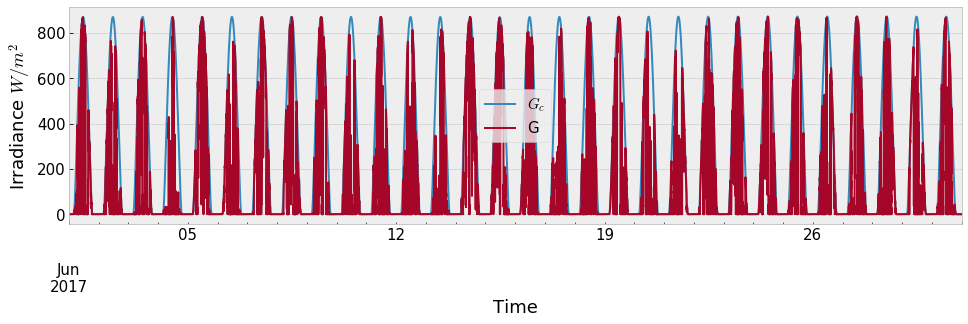

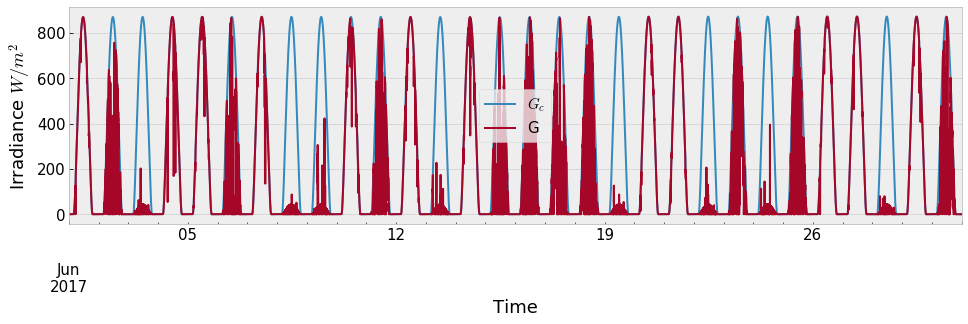

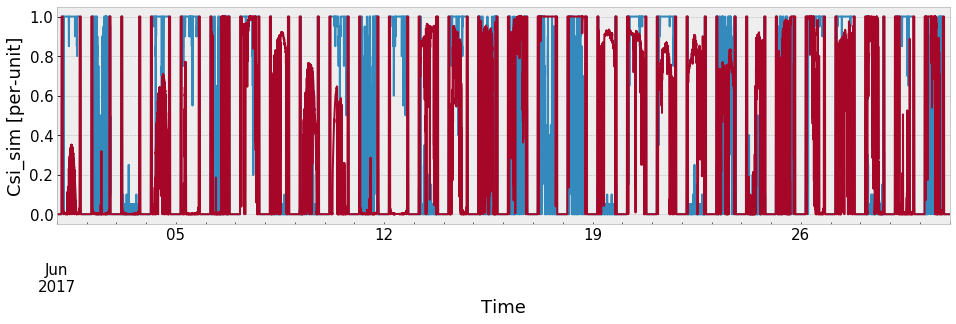

In [16]:
plt.rcParams['figure.figsize']=(16,4)
plt.style.use('bmh')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots()
if DataSource == 'Location 1':
    DF['2017-06']['CGHI'].plot()
    DF['2017-06']['GHI'].plot()
elif DataSource == 'Location 2':
    DF['2011-06']['CGHI'].plot()
    DF['2011-06']['GHI'].plot()
ax.set_ylabel('Irradiance $W/m^2$');
plt.legend(["$G_c$", "G"])
plt.savefig('Figures/real_timeser.pdf',bbox_inches='tight')

fig, ax = plt.subplots()
if DataSource == 'Location 1':
    DF['2017-06']['CGHI'].plot()
    DF['2017-06']['GHI_sim2'].plot()
elif DataSource == 'Location 2':
    DF['2011-06']['CGHI'].plot()
    DF['2011-06']['GHI_sim2'].plot()
ax.set_ylabel('Irradiance $W/m^2$');
plt.legend(["$G_c$", "G"])
plt.savefig('Figures/model1_timeser.pdf',bbox_inches='tight')

fig, ax = plt.subplots()
if DataSource == 'Location 1':
    DF['2017-06']['CGHI'].plot()
    DF['2017-06']['GHI_sim'].plot()
elif DataSource == 'Location 2':
    DF['2011-06']['CGHI'].plot()
    DF['2011-06']['GHI_sim'].plot()
ax.set_ylabel('Irradiance $W/m^2$');
plt.legend(["$G_c$", "G"])
plt.savefig('Figures/model2_timeser.pdf',bbox_inches='tight')


fig, ax = plt.subplots()
if DataSource == 'Location 1':
    DF['2017-06']['CSI_sim'].plot();
    DF['2017-06']['CSI'].plot();
elif DataSource == 'Location 2':
    DF['2011-06']['CSI_sim'].plot();
    DF['2011-06']['CSI'].plot();
ax.set_ylabel('Csi_sim [per-unit]');

# Plotting MAR

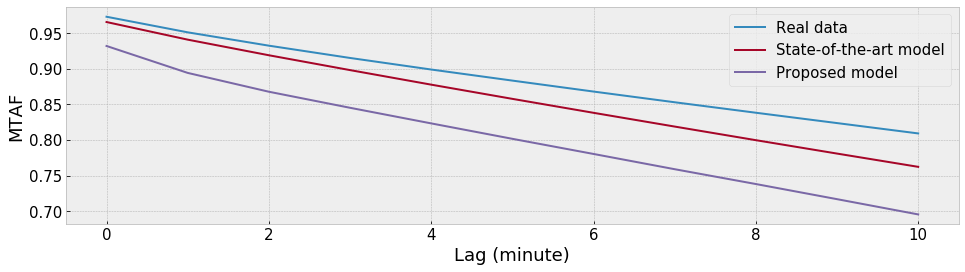

In [17]:
df = pd.DataFrame()
df['a'] = DF['CSI']
df['b'] = DF['CSI_sim']
df['c'] = DF['CSI_sim2']
df2 = df
df2 = df2.resample('1d').var()
df2 = df2.resample(resolution).pad()
df = df.resample('1d').mean()
df = df.resample(resolution).pad()
df['a2'] = df2['a']
df['b2'] = df2['b']
df['c2'] = df2['c']
df['d'] = DF['CSI']
df['e'] = DF['CSI_sim']
df['f'] = DF['CSI_sim2']
ac1 = np.array([])
ac2 = np.array([])
ac3 = np.array([])
Tau = 25
for tau in range(1,12):
    df['g'] = (df['d'] - df['a'])*(df['d'].shift(periods=-tau) - df['a'])/(df['a2'])
    df['h'] = (df['e'] - df['b'])*(df['e'].shift(periods=-tau) - df['b'])/(df['b2'])
    df['i'] = (df['f'] - df['c'])*(df['f'].shift(periods=-tau) - df['c'])/(df['c2'])
    ac1 = np.append(ac1, df['g'].mean())
    ac2 = np.append(ac2, df['h'].mean())
    ac3 = np.append(ac3, df['i'].mean())
fig, ax = plt.subplots()  
plt.rcParams['figure.figsize']=(16, 4)
plt.style.use('bmh')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams.update({'font.size': 15})

plt.plot(ac1)
plt.plot(ac3)
plt.plot(ac2)
plt.xlabel("Lag (minute)")
plt.ylabel("MTAF")
plt.legend(["Real data", "State-of-the-art model", "Proposed model"])
plt.savefig('Figures/MAR_func.pdf',bbox_inches='tight')
plt.show()

# Plotting AR

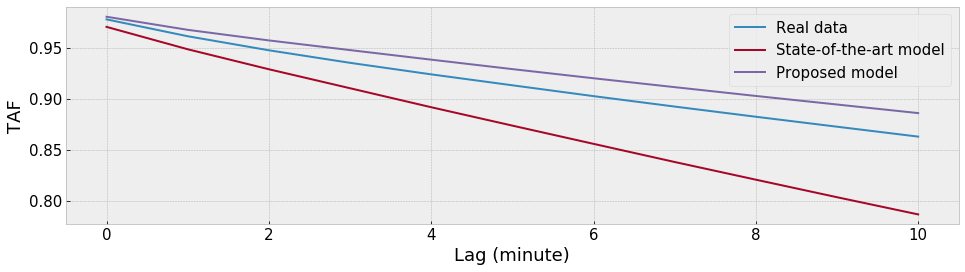

In [18]:
df = pd.DataFrame()
df['a'] = DF['CSI']
df['b'] = DF['CSI_sim']
df['c'] = DF['CSI_sim2']
df2 = df
df2 = df2.resample('1y').var()
df2 = df2.resample(resolution).pad()
df = df.resample('1y').mean()
df = df.resample(resolution).pad()
df['a2'] = df2['a']
df['b2'] = df2['b']
df['c2'] = df2['c']
df['d'] = DF['CSI']
df['e'] = DF['CSI_sim']
df['f'] = DF['CSI_sim2']
ac1 = np.array([])
ac2 = np.array([])
ac3 = np.array([])
for tau in range(1,12):
    df['g'] = (df['d'] - df['a'])*(df['d'].shift(periods=-tau) - df['a'])/(df['a2'])
    df['h'] = (df['e'] - df['b'])*(df['e'].shift(periods=-tau) - df['b'])/(df['b2'])
    df['i'] = (df['f'] - df['c'])*(df['f'].shift(periods=-tau) - df['c'])/(df['c2'])
    ac1 = np.append(ac1, df['d'].autocorr(lag=tau))
    ac2 = np.append(ac2, df['e'].autocorr(lag=tau))
    ac3 = np.append(ac3, df['f'].autocorr(lag=tau))
fig, ax = plt.subplots()  
plt.rcParams['figure.figsize']=(16, 4)
plt.style.use('bmh')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams.update({'font.size': 15})

plt.plot(ac1)
plt.plot(ac3)
plt.plot(ac2)
plt.xlabel("Lag (minute)")
plt.ylabel("TAF")
plt.legend(["Real data", "State-of-the-art model", "Proposed model"])
plt.savefig('Figures/AR_func.pdf',bbox_inches='tight')
plt.show()

In [ ]:
# import os
# os.system('jupyter nbconvert --to html NoteBook.ipynb')